# Bayesian Correlation with PyMC3

In this notebook, I show how to determine a correlation coefficient within the Bayesian framework both in a simply and a robust way. The correlation can be seen as a direct alternative to the traditional Pearson correlation coefficient.

The original implementation for PyMC2 is available at http://www.philippsinger.info/?p=581

The model and code shown here is motivated by the following blog posts and the book "Bayesian Cognitive Modeling":

* http://www.sumsar.net/blog/2013/08/bayesian-estimation-of-correlation/
* http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/
* http://bayesmodels.com/

My main contribution here is to show how do apply the model with Python and PyMC.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette='husl') 

### Model

First, let us start with defining our model both for the classic way of using a multivariate normal distribution as well as for the robust way that utilizes a multivariate student t-distribution.

In [2]:
import pymc3 as pm
import numpy as np
import theano.tensor as T

In [3]:
def precision(sigma, rho):
    C = T.alloc(rho, 2, 2)
    C = T.fill_diagonal(C, 1.)
    S = T.diag(sigma)
    return T.nlinalg.matrix_inverse(S.dot(C).dot(S))


def analyze(data):
    with pm.Model() as model:
        # priors might be adapted here to be less flat
        mu = pm.Normal('mu', mu=0., tau=0.000001, shape=2, testval=np.mean(data, axis=1))
        sigma = pm.Uniform('sigma', lower=1e-6, upper=1000., shape=2, testval=np.std(data, axis=1))
        rho = pm.Uniform('r', lower=-1., upper=1., testval=0)

        prec = pm.Deterministic('prec', precision(sigma, rho))
        mult_n = pm.MvNormal('mult_n', mu=mu, tau=prec, observed=data.T)

    return model

### Data

Let us define some data.

In [4]:
x = np.array([525., 300., 450., 300., 400., 500., 550., 125., 300., 400., 500., 550.])
y = np.array([250., 225., 275., 350., 325., 375., 450., 400., 500., 550., 600., 525.])
data = np.array([x, y])

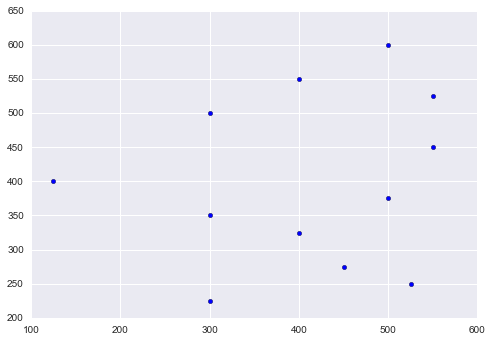

In [5]:
plt.scatter(x, y)

### Inference

And now, we can do the inference. First, with the classic (non-robust) model.

In [6]:
model = analyze(data)
with model:
    trace = pm.sample(50000, tune=25000, step=pm.Metropolis())

100%|██████████| 50000/50000 [00:34<00:00, 1440.73it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34314a9eb8>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f3430cdf748>]], dtype=object)

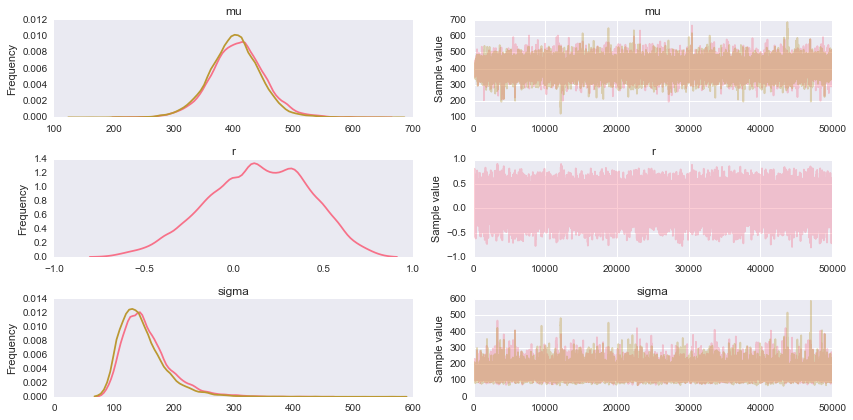

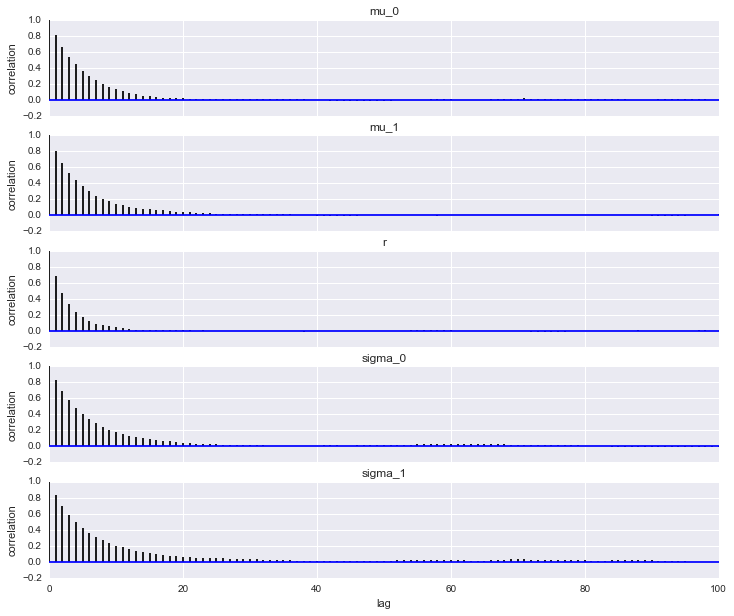

In [7]:
pm.traceplot(trace, varnames=['mu', 'r', 'sigma'])
pm.autocorrplot(trace, varnames=['mu', 'r', 'sigma'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f34308999e8>], dtype=object)

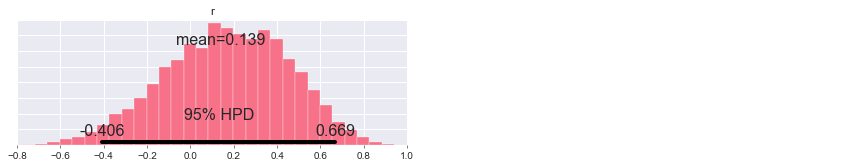

In [8]:
pm.plot_posterior(trace, varnames=['r'])

So the mean correlation (rho) is around 0.14. However, when we take a look at the histogram of the marginal posterior for rho, we can see that the frequency of distinct values for rho are pretty wide. We can characterize this with the 95% HDP (highest probability density) interval---also called credible interval---which is [-0.418 0.668]. Thus, with this HDP, we can get a very thorough view regarding the distribution of the parameters for rho. While the mean correlation is slightly positive, we cannot rule out a negative correlation or a non-existing correlation (rho=0). Actually, we can just count the number of times rho is positive by looking at the trace of rho. This can be seen as a Bayesian way of accepting or rejecting hypotheses (so-called ROPEs). A discussion about this can be found in one of John Kruschke's [blog posts](http://doingbayesiandataanalysis.blogspot.de/2013/08/how-much-of-bayesian-posterior.html).

In [9]:
(trace.get_values('r') > 0.05).mean()

0.63085999999999998

As a result, we see that only around 64% of all values of the posterior are above 0.05. Thus, we only see mediocre evidence for a positive correlation in the data.

Let us now relax this assumption and just determine what the probability is that there is no correlation at all (regardless negative or positive) with a ROPE of [0.05,0.05].

In [10]:
((trace.get_values('r') < 0.05) & (trace.get_values('r') > -0.05)).mean()

0.1115

We can only see week evidence that there is no correlation at all. Thus, the probability that there is a negative correlation is around 27%. Overall, the inference and our inspection of the marginal posterior reveals that there might be a slight tendency towards a positive correlation, but we are pretty unsure about it. We might want to gather further data to supplement our inference.

Let us now compare these results to a classic Pearson correlation coefficient:

In [11]:
from scipy.stats.stats import pearsonr
pearsonr(x, y)

(0.1746680664120466, 0.58716519218300223)

Not surprisingly, our Bayesian rho values is very similar to the one determined by the Pearson correlation coefficient. The p-value states that we cannot reject the null hypothesis that there is no correlation (two-sided).

## More data

Let us take a look at a further dataset taken from the [blog post](http://www.sumsar.net/blog/2013/08/bayesian-estimation-of-correlation/) by Rasmus Bååth linked at the beginning of this post.

In [12]:
s = [9.92,94,9.94,79,9.97,78,9.93,83,9.90,77,9.93,76,10.00,74,9.97,87,10.00,86,10.01,83,10.08,75,10.09,74,10.15,92,10.15,69,10.17,79,10.17,71,10.19,80,10.30,80,10.31,77,10.34,87]
x = [float(a) for i,a in enumerate(s) if i % 2 == 0]
y = [float(a) for i,a in enumerate(s) if i % 2 != 0]
data = np.array([x, y])

In [13]:
model = analyze(data)
with model:
    trace = pm.sample(50000, tune=25000, step=pm.Metropolis())

100%|██████████| 50000/50000 [00:35<00:00, 1389.87it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f34364d2080>], dtype=object)

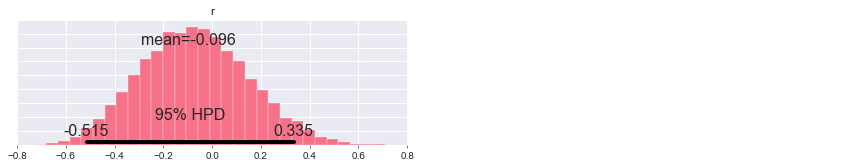

In [14]:
pm.plot_posterior(trace, varnames=['r'])

We can see a slight negative correlation, however the 95% HDP interval again is very wide and also includes a correlation zero and positive correlation. The Pearson correlation shows similar results, but claims no statistical significance.

In [15]:
pearsonr(x, y)

(-0.10965237912730059, 0.64537479933386654)

What happens, if we add an outlier to the data as elaborated in the follow-up [blog post](http://www.sumsar.net/blog/2013/08/bayesian-estimation-of-correlation/) by Rasmus Bååth.

In [16]:
x.append(9.5)
y.append(115.)
data = np.array([x, y])

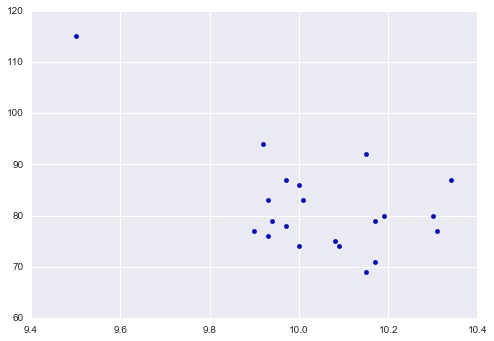

In [17]:
plt.scatter(x, y)

In [18]:
model = analyze(data)
with model:
    trace = pm.sample(50000, tune=25000, step=pm.Metropolis())

100%|██████████| 50000/50000 [00:35<00:00, 1398.71it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3430eaa518>], dtype=object)

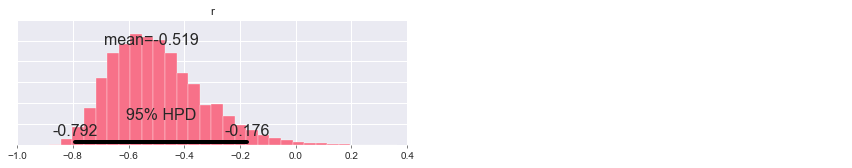

In [19]:
pm.plot_posterior(trace, varnames=['r'])

Suddenly, only this one data point, changed the results drastically. The inference now indicates a strong negative correlation and the 95% HDP interval contains only negative correlations. Here, we would for sure claim a strong belief in negative correlation according to our analysis.

In [20]:
pearsonr(x, y)

(-0.56990140833523373, 0.0069939604634016196)

Not surprisingly, the Pearson correlation again agrees with our Bayesian inference and states the correlation as significant. This is not surprising, as the Pearson correlation is very non-robust to non-normality of the data as it is a measure of linear dependence. The same happends of course with our Bayesian model that models the data with a normal distribution.

Thus, we make our model more robust as elaborated in cited [blog post](http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/). What we actually want, is a model that assumes that the majority of the data is normally distributed, but still allows outliers to exist. Within our Bayesian framework, we can choose any model for the likelihood. In that case, a robust model is the multivariate student t-distribution, which is defined as
$$f(\mathbf{x}| \nu,\mu,\Sigma) = \frac{\Gamma\left[(\nu+p)/2\right]}{\Gamma(\nu/2)\nu^{p/2}\pi^{p/2}\left|{\Sigma}\right|^{1/2}}\left[1+\frac{1}{\nu}({\mathbf x}-{\mu})^T{\Sigma}^{-1}({\mathbf x}-{\mu})\right]^{-(\nu+p)/2}.$$
For a detailed discussion please refer to corresponding [blog post](http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/).

Now, let us apply the robust model (multivariate student t-distribution).

In [28]:
from theano.printing import Print

def mad(data, axis=None):
    return np.median(np.absolute(data - np.median(data, axis)), axis)


def covariance(sigma, rho):
    C = T.alloc(rho, 2, 2)
    C = T.fill_diagonal(C, 1.)
    S = T.diag(sigma)
    return S.dot(C).dot(S)


def analyze_robust(data):
    with pm.Model() as model:
        # priors might be adapted here to be less flat
        mu = pm.Normal('mu', mu=0., tau=0.000001, shape=2, testval=np.median(data, axis=1))
        sigma = pm.Uniform('sigma', lower=0, upper=1000, shape=2, testval=mad(data.T, axis=0))
        rho = pm.Uniform('r', lower=-1., upper=1., testval=0.5)
        sigma_p = Print('sigma')(sigma)

        cov = pm.Deterministic('cov', covariance(sigma_p, rho))
        nu = pm.Exponential('nu_minus_one', lam=1./29.) + 1
        mult_t = pm.MvStudentT('mult_t', nu=nu, mu=mu, Sigma=cov, observed=data.T)

    return model

In [30]:
robust_model = analyze_robust(data)
with robust_model:
    robust_trace = pm.sample(50, tune=25, step=pm.Metropolis(), progressbar=False)

sigma __str__ = [ 0.09  4.  ]
sigma __str__ = [ 0.09  4.  ]
sigma __str__ = [ 0.09  4.  ]
sigma __str__ = [ 0.09  4.  ]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.09  4.  ]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.17113166  3.27659329]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.13320951  3.7383861 ]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [  1.15987578e-02   3.54608165e+01]
sigma __str__ = [ 0.07297845  5.03607248]
sigma __str__ = [ 0.07297845  5.03607248]


In [ ]:
pm.summary(robust_trace, varnames=['r', 'sigma', 'mu'])

In [ ]:
pm.traceplot(robust_trace, varnames=['r', 'nu_minus_one', 'sigma', 'mu'])

In [ ]:
pm.plot_posterior(robust_trace, varnames=['r'])